✅ Libraries imported and setup complete.
Mounted at /content/drive
🔄 Loading processed data from: /content/drive/MyDrive/Colab Notebooks/datasets/processed/
✅ Data loaded successfully.

--- Creating a Representative Sample (50,000 points) ---
✅ Sample created with shape: (50000, 78)

--- Starting Dimensionality Reduction Analysis ---
Running PCA...
PCA Variance Explained by 2 components: 74.08%


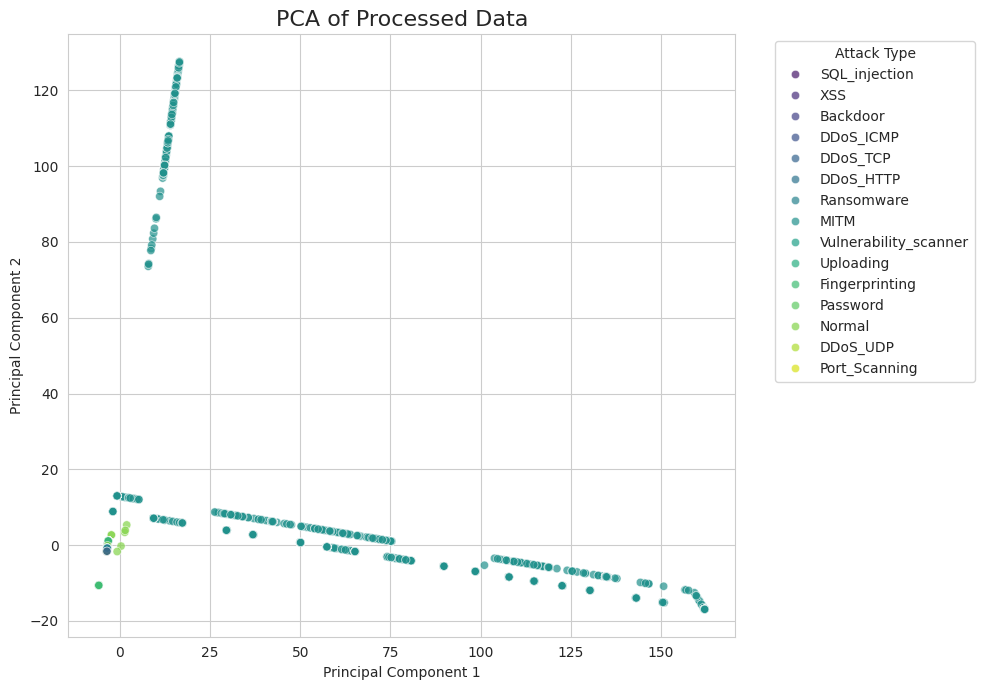


Running t-SNE (this may take a few minutes)...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


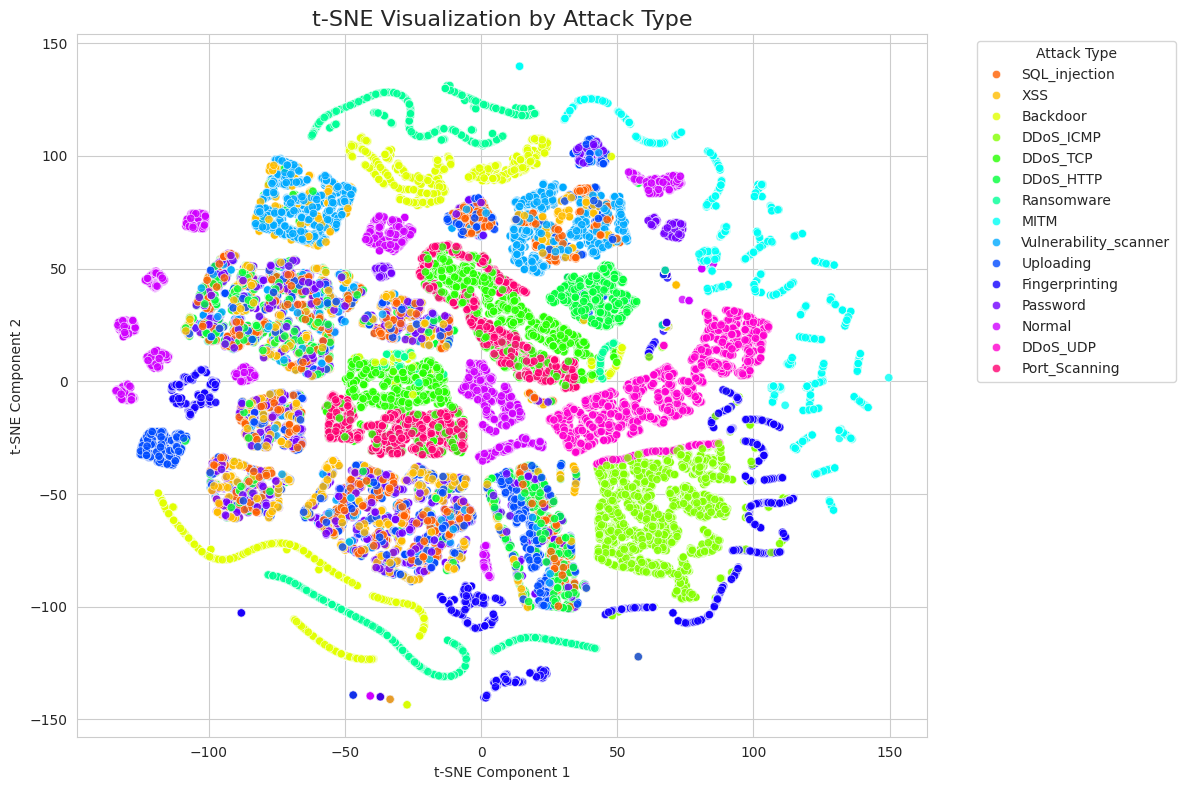

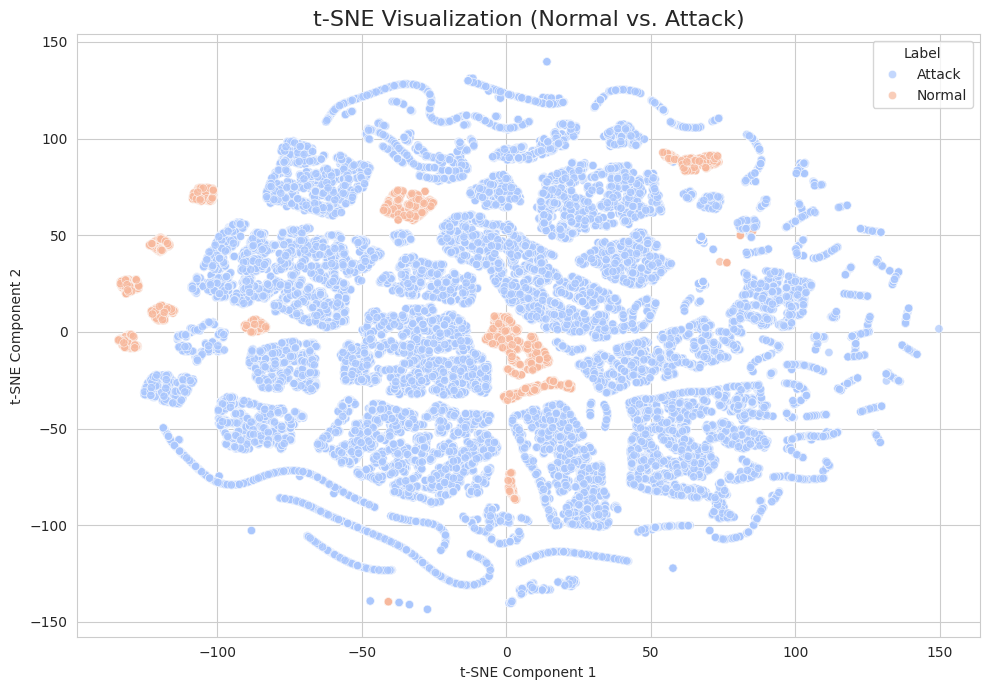


--- Starting SHAP Value Analysis ---
Training a memory-efficient RandomForest for SHAP analysis...
✅ Model training complete.
✅ SHAP values calculated.

Generating global feature importance plot...


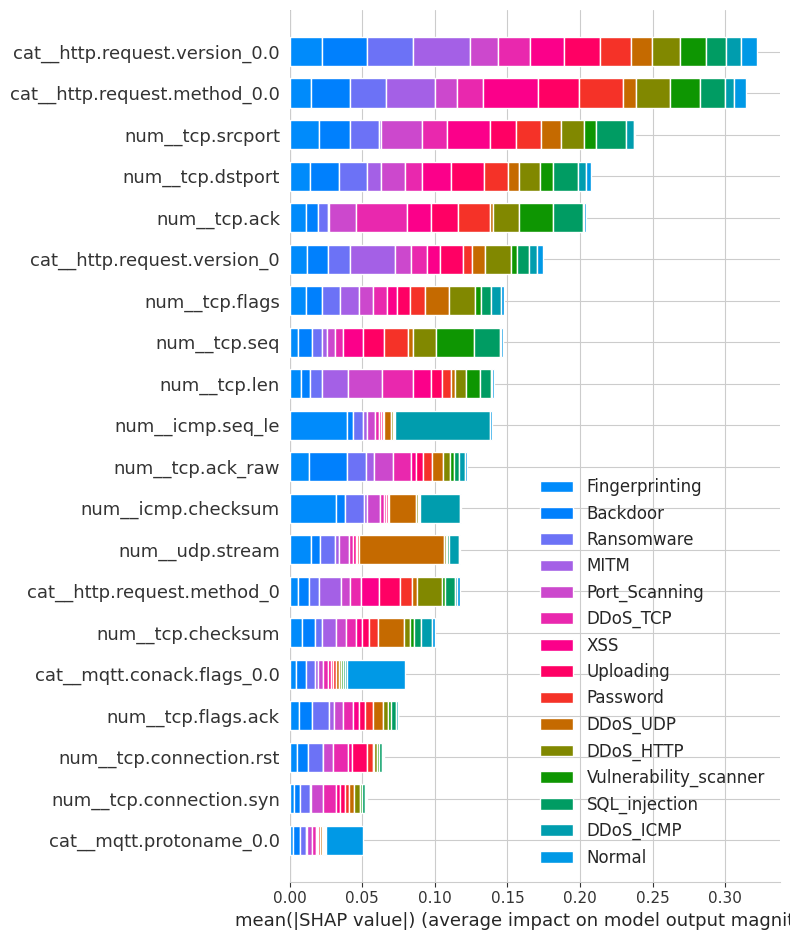

<Figure size 640x480 with 0 Axes>


Generating class-wise feature importance plot...


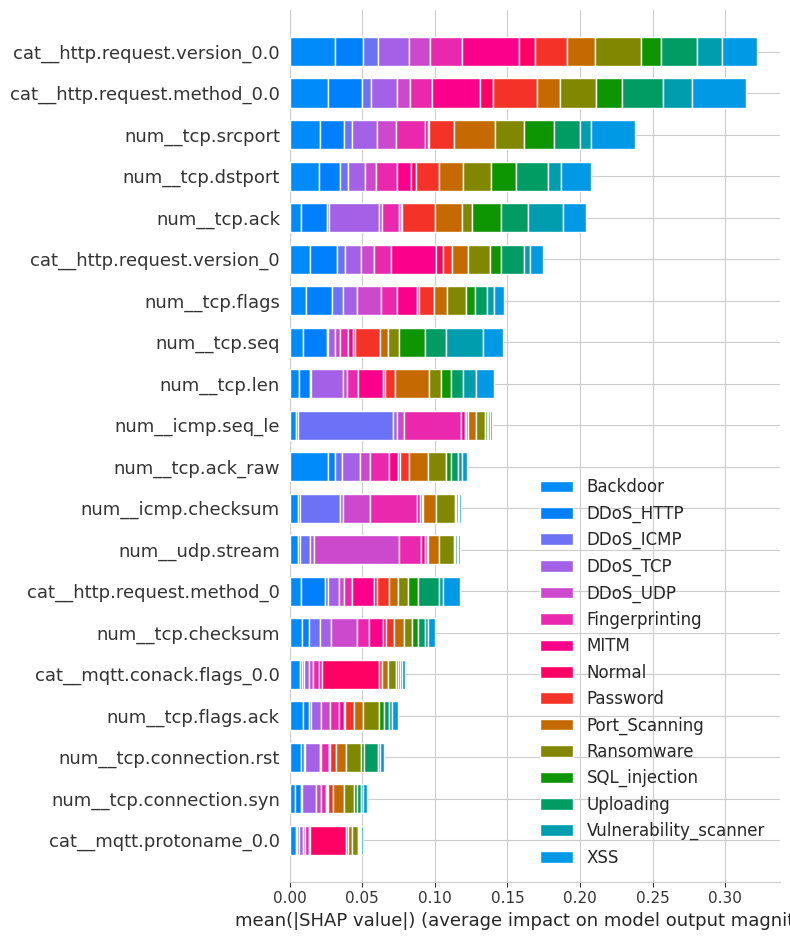

<Figure size 640x480 with 0 Axes>


--- Advanced EDA Script Finished ---


In [ ]:
# -*- coding: utf-8 -*-
"""
3- Advanced Exploratory Data Analysis for Edge-IIoTset

This script performs advanced EDA on the pre-cleaned dataset. It focuses on:
1. Dimensionality reduction (PCA vs. t-SNE) for cluster visualization.
2. Model-agnostic feature explanation using SHAP values.
3. Saving all visualizations as high-resolution figures for publication.
"""

c
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths
load_path = '/content/drive/MyDrive/Colab Notebooks/datasets/processed/'
figure_save_path = '/content/drive/MyDrive/Colab Notebooks/datasets/figures/'
os.makedirs(figure_save_path, exist_ok=True) # Create folder for figures

print(f"🔄 Loading processed data from: {load_path}")
try:
    X_train_resampled_df = joblib.load(os.path.join(load_path, 'X_train_resampled.joblib'))
    y_train_resampled = joblib.load(os.path.join(load_path, 'y_train_resampled.joblib'))
    label_encoder = joblib.load(os.path.join(load_path, 'label_encoder.joblib'))
    # Ensure X is a DataFrame for SHAP
    if isinstance(X_train_resampled_df, np.ndarray):
         X_train_resampled_df = pd.DataFrame(X_train_resampled_df, columns=[f'feature_{i}' for i in range(X_train_resampled_df.shape[1])])

    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print(f"❌ ERROR: Processed data not found. Please run the main preprocessing script first.")
    # Exit gracefully if data is not available
    # exit()


# --- 3. Create a Representative Sample for Visualization ---
# To speed up visualization (PCA, t-SNE, SHAP), we create a smaller, stratified sample
# from the large, resampled training dataset.
print("\n--- Creating a Representative Sample (50,000 points) ---")
from sklearn.model_selection import StratifiedShuffleSplit

n_samples_for_viz = 50000
# Ensure we don't sample more than available data
if len(X_train_resampled_df) < n_samples_for_viz:
    n_samples_for_viz = len(X_train_resampled_df)

sss = StratifiedShuffleSplit(n_splits=1, test_size=n_samples_for_viz, random_state=42)
for _, index in sss.split(X_train_resampled_df, y_train_resampled):
    X_sample = X_train_resampled_df.iloc[index]
    y_sample = y_train_resampled[index]

print(f"✅ Sample created with shape: {X_sample.shape}")


# --- 4. Dimensionality Reduction & Visualization (PCA vs. t-SNE) ---
print("\n--- Starting Dimensionality Reduction Analysis ---")

## PCA Analysis ##
print("Running PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)
print(f"PCA Variance Explained by 2 components: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=label_encoder.inverse_transform(y_sample),
                palette="viridis", alpha=0.7)
plt.title('PCA of Processed Data', fontsize=16)
plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'pca_plot.png'), dpi=300)
plt.show()

## t-SNE Analysis (Multi-Class and Binary) ##
print("\nRunning t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

# Plot 1: t-SNE colored by Multi-Class Attack_type
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=label_encoder.inverse_transform(y_sample),
                palette=sns.color_palette("hsv", n_colors=15), alpha=0.8)
plt.title('t-SNE Visualization by Attack Type', fontsize=16)
plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'tsne_multiclass_plot.png'), dpi=300)
plt.show()

# Plot 2: t-SNE colored by Binary Attack_label (Normal vs. Attack)
# Get binary labels: 1 if not 'Normal', 0 if 'Normal'
normal_class_index = list(label_encoder.classes_).index('Normal')
y_sample_binary = np.where(y_sample == normal_class_index, 'Normal', 'Attack')
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sample_binary, palette="coolwarm", alpha=0.7)
plt.title('t-SNE Visualization (Normal vs. Attack)', fontsize=16)
plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2')
plt.legend(title='Label')
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'tsne_binary_plot.png'), dpi=300)
plt.show()


# --- 5. Model-Agnostic Feature Explanation with SHAP ---
print("\n--- Starting SHAP Value Analysis ---")

# Train a memory-efficient Random Forest model on the SAMPLE for explanation
# max_samples makes training faster and lighter on RAM
print("Training a memory-efficient RandomForest for SHAP analysis...")
feature_model = RandomForestClassifier(n_estimators=100, max_samples=0.5, random_state=42, n_jobs=-1)
feature_model.fit(X_sample, y_sample)
print("✅ Model training complete.")

# Calculate SHAP values
explainer = shap.TreeExplainer(feature_model)
shap_values = explainer.shap_values(X_sample)
print("✅ SHAP values calculated.")

## Global Feature Importance (SHAP Summary Plot) ##
print("\nGenerating global feature importance plot...")
plt.title("SHAP Summary Plot: Global Feature Importance", fontsize=16)
shap.summary_plot(shap_values, X_sample, plot_type="bar",
                  class_names=label_encoder.classes_, max_display=20)
# The SHAP plot function handles its own saving, but we can try to force it
fig = plt.gcf()
fig.savefig(os.path.join(figure_save_path, 'shap_global_importance.png'), dpi=300, bbox_inches='tight')
plt.show()


## Class-wise Feature Importance ##
print("\nGenerating class-wise feature importance plot...")
plt.title("SHAP Summary: Feature Importance by Attack Type", fontsize=16)
shap.summary_plot(shap_values, X_sample, plot_type="bar",
                  class_names=label_encoder.classes_, max_display=20, class_inds='original')
fig = plt.gcf()
fig.savefig(os.path.join(figure_save_path, 'shap_classwise_importance.png'), dpi=300, bbox_inches='tight')
plt.show()


print("\n--- Advanced EDA Script Finished ---")